In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt; plt.set_cmap('gray')
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from mesh_detection.dataset import FaceDataset
from mesh_detection.batch_iter import batch_iterator
from mesh_detection.utils import add_channel_dim, randomly_flip, show_key_points, to_torch, to_np, sequence_to_torch
from mesh_detection.split import train_val_test_split, stratified_train_val_test_split
from mesh_detection.model import BitNet, predict
from mesh_detection.train import validator, train, criterion
from mesh_detection.metric import l2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Dataset

In [3]:
kaggle_face_path = Path('../../kaggle_face/training.csv')

In [4]:
ds = FaceDataset(kaggle_face_path)

In [5]:
i = np.random.choice(ds.ids)

In [6]:
img = ds.load_image(i)
kps = ds.load_key_points(i)

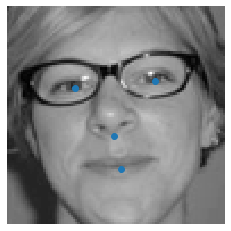

In [7]:
plt.axis('off')
plt.imshow(img)
show_key_points(kps)

# Split

In [8]:
contain_nans = [np.any(np.isnan(ds.load_key_points(i))) for i in ds.ids]

In [9]:
train_ids, val_ids, test_ids = stratified_train_val_test_split(ds.ids, labels=contain_nans)[0]

# Batch iterator

In [10]:
batch_iter = batch_iterator(ds.load_image, ds.load_key_points, train_ids[:100], 50, randomly_flip, add_channel_dim)

In [11]:
batch_iter

<function mesh_detection.batch_iter.batch_iterator.<locals>.iterate_batches()>

# Model

In [12]:
stucture = [
    [[1, 16, 16],                     [16, 32, 32]],
        [[16, 32, 32],                [32, 64, 64]],
            [[32, 64, 64],            [64, 128, 128]],
                [[64, 128, 128],      [128, 256, 256]],
                    [[128, 256, 256], [256, 512, 512]],
                        [256, 512, 512]
]

n_points = 15
conv_block = partial(nn.Conv2d, kernel_size=3, padding=1)
pooling = partial(nn.MaxPool2d, kernel_size=2)

model = BitNet(stucture, n_points, conv_block, pooling).to(device)

# Train

In [13]:
optimizer = Adam(model.parameters(), lr=1e-3)

In [14]:
validate = validator(val_ids, ds.load_image, ds.load_key_points, {'l2': l2})

In [15]:
%time model, losses, val_metrics = train(model, batch_iter, optimizer, criterion, n_epochs=3, validate=validate)


CPU times: user 2min 36s, sys: 3min 18s, total: 5min 54s
Wall time: 13.3 s


In [16]:
val_metrics

{'l2': [array([68.52731 , 40.556046, 62.112976, 75.613716, 44.183113, 35.065937,
         54.64218 , 79.66975 , 40.19076 , 26.68202 , 69.951225, 91.04402 ,
         74.937675, 80.33165 , 83.50834 ], dtype=float32),
  array([67.70151 , 38.883827, 60.56678 , 74.28905 , 42.934288, 34.040726,
         54.112564, 78.85206 , 39.618835, 25.677273, 69.01877 , 89.21194 ,
         73.69868 , 78.94028 , 82.890144], dtype=float32),
  array([67.32505 , 38.770683, 60.40328 , 74.19124 , 42.643   , 34.031635,
         54.093338, 78.77751 , 39.610558, 25.670057, 68.997154, 88.98481 ,
         73.13233 , 78.88164 , 82.88417 ], dtype=float32)]}

In [17]:
losses

[2344.04, 2126.3296, 2089.544]